In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error as mape

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["figure.figsize"] = (16, 10)

<IPython.core.display.Javascript object>

--------------------------------------------------------------------------------

## Read Data

In [4]:
trips = pd.read_csv("../data/trips/daily_trips.csv")
trips.date = pd.to_datetime(trips.date)
trips.rename(columns={"date": "ds", "daily_trips": "y"}, inplace=True)

weather = pd.read_csv("../data/weather/daily_weather.csv")
weather.date = pd.to_datetime(weather.date)
weather.rename(
    columns={
        "date": "ds",
        "Normal_Max_Temp_C": "tmax",
        "Normal_Min_Temp_C": "tmin",
        "Normal_Precipitation_CM": "precip",
    },
    inplace=True,
)

trips = pd.merge(trips, weather, on="ds", how="left")

holidays = pd.read_csv("../data/holidays/holidays.csv")
holidays.ds = pd.to_datetime(holidays.ds)

<IPython.core.display.Javascript object>

In [5]:
trips["dow"] = trips.ds.dt.dayofweek
trips["month"] = trips.ds.dt.month
trips = pd.get_dummies(trips, prefix="dow", columns=["dow"], drop_first=True)
trips = pd.get_dummies(trips, prefix="month", columns=["month"], drop_first=True)
trips.sort_values('ds', inplace=True)
trips["t"] = (trips.ds - trips.ds.min()).astype('int64')


/home/allen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


<IPython.core.display.Javascript object>

## Simple Forecast

Use Prophet to create a simple forecast.  Don't do any tuning, CV, etc, just create a forecast on one training dataset and test the performance on a test dataset

In [6]:
train = trips[trips.ds <= "2016-12-31"]
test = trips[trips.ds >= "2017-01-01"]

test.sort_values("ds", inplace=True)
train.sort_values("ds", inplace=True)
feature_cols = [col for col in train.columns if col not in ["ds", "y", "tmin"]]
X_train = train[feature_cols]
X_test = test[feature_cols]

/home/allen/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


<IPython.core.display.Javascript object>

In [7]:
mod = Lasso(alpha=0.0001, max_iter=10000)
mod.fit(X_train, train["y"])

Lasso(alpha=0.0001, max_iter=10000)

<IPython.core.display.Javascript object>

In [8]:
lr_preds = mod.predict(X_test)

<IPython.core.display.Javascript object>

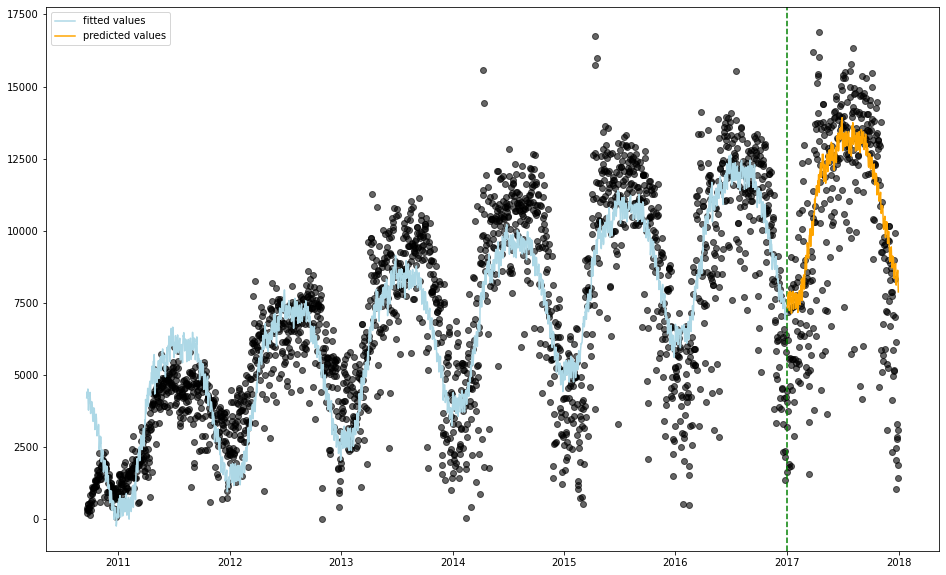

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(train.ds, mod.predict(X_train), color="lightblue", label="fitted values")
ax.scatter(train.ds, train.y, color="black", alpha=0.6)
ax.scatter(test.ds, test.y, color="black", alpha=0.6)
ax.axvline(dt.datetime(2017, 1, 1), color="green", linestyle="dashed")
ax.plot(test.ds, mod.predict(X_test), color="orange", label="predicted values")
ax.legend()
plt.show()

In [10]:
testset = pd.DataFrame({"ds": test.ds, "yhat": lr_preds})
testset = pd.merge(left=testset, right=test[["ds", "y"]], how="outer", on="ds")

<IPython.core.display.Javascript object>

In [11]:
testset.head()

,ds,yhat,y
0,2017-01-01,7337.120779,4063
1,2017-01-02,7422.707034,1638
2,2017-01-03,7767.833364,3771
3,2017-01-04,7750.164385,7185
4,2017-01-05,7872.807617,6214


<IPython.core.display.Javascript object>

In [12]:
mape(y_true=testset.y, y_pred=testset.yhat)

0.3701722682699958

<IPython.core.display.Javascript object>